In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

# Set the random seed for reproducibility
np.random.seed(2417)

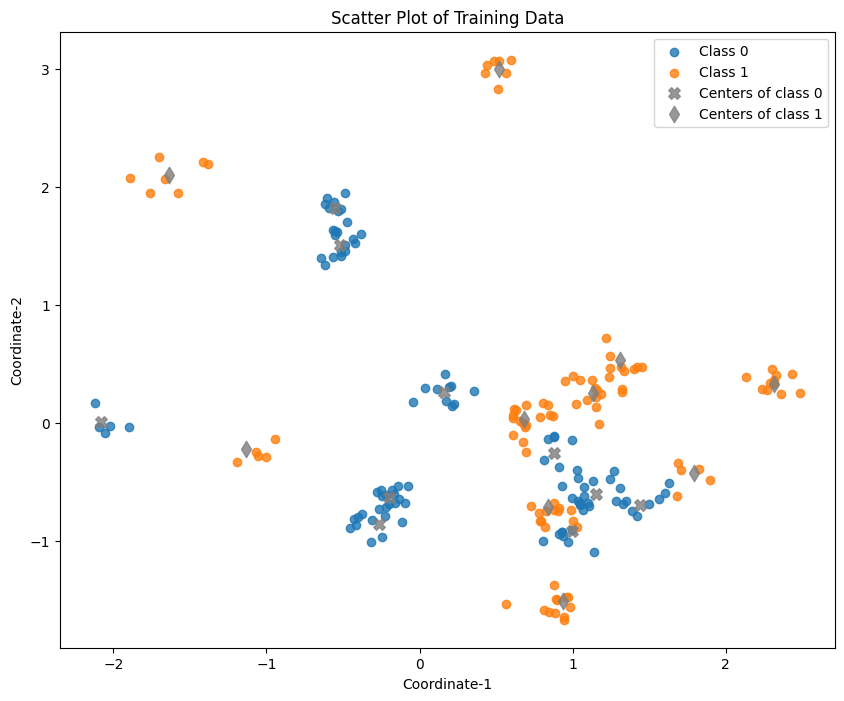

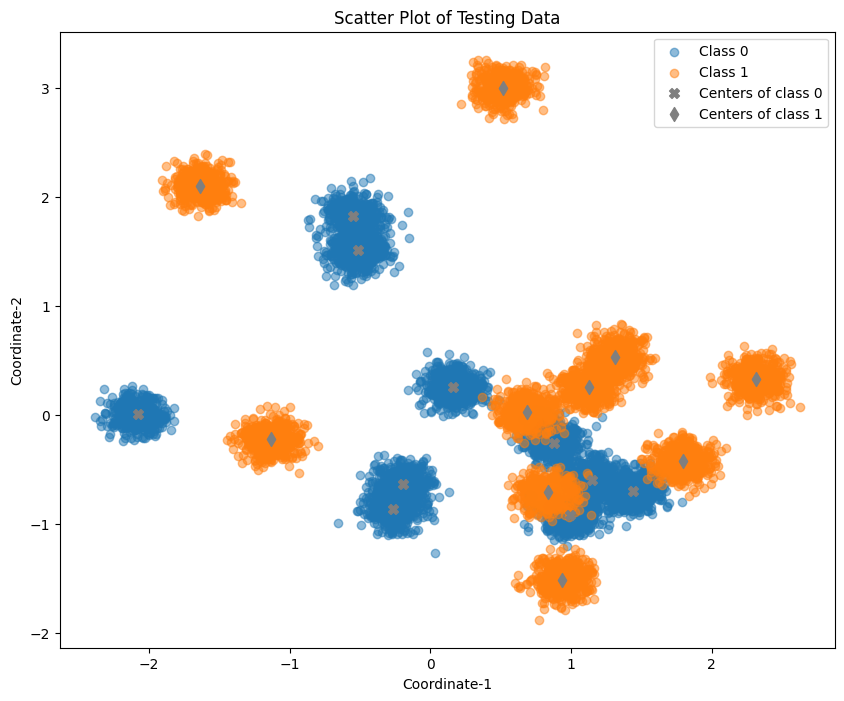

In [2]:
# Part 1: Generate Data

# Generate 20 2-dimension centers from a normal distribution:
# the first ten items in the center pool correspond to the first class, i.e. y = 0
# and the other ten items correpond to the second class, i.e. y = 1
num_centers = 20
centers = np.random.normal(size=(num_centers, 2))

# Generate training and test samples:
num_samples_train = 100
num_samples_test = 5000
var = 0.1

def data_generation(num,centers,var): 
    
    dataset = np.empty((num*2,3))
    for k in [0,1]:
        for i in range(num):
            icenter = random.randint(k*10+0, k*10+9) # randomly pick up a center from the pool
            isamples = np.random.normal(centers[icenter],var) 
            # retrieve the coordinates of the center and generate a 2d data point centered at the selected center
            
            dataset[k*num + i,0] = isamples[0]
            dataset[k*num + i,1] = isamples[1]
            dataset[k*num + i,2] = k # save of the value of y(0 or 1) into the dataset 
            
    dataset = np.vstack(dataset)
    return(dataset)

train_data = data_generation(num_samples_train,centers,var)
test_data = data_generation(num_samples_test,centers,var)

# Generate scatter plots of training data and the centers

plt.figure(figsize=(10, 8))

plt.scatter(train_data[train_data[:,2]==0, 0], train_data[train_data[:,2]==0, 1], label=f"Class 0", alpha=0.8)
plt.scatter(train_data[train_data[:,2]==1, 0], train_data[train_data[:,2]==1, 1], label=f"Class 1", alpha=0.8)
plt.scatter(centers[0:10,0],centers[0:10,1], marker = 'X', color = 'tab:gray',s = 70,label=f"Centers of class 0", alpha=0.8)
plt.scatter(centers[10:20,0],centers[10:20,1], marker = 'd',color = 'tab:gray', s = 70, label=f"Centers of class 1", alpha=.8)

plt.xlabel('Coordinate-1')
plt.ylabel('Coordinate-2')
plt.title('Scatter Plot of Training Data')
plt.legend()
plt.grid(False)
plt.show()

# Step 4: Generate scatter plots of testing data and the centers

plt.figure(figsize=(10, 8))

plt.scatter(test_data[test_data[:,2]==0, 0], test_data[test_data[:,2]==0, 1], label=f"Class 0", alpha=0.5)
plt.scatter(test_data[test_data[:,2]==1, 0], test_data[test_data[:,2]==1, 1], label=f"Class 1", alpha=0.5)
plt.scatter(centers[0:10,0],centers[0:10,1], marker = 'X', color = 'tab:gray', s = 50,label=f"Centers of class 0", alpha=1)
plt.scatter(centers[10:20,0],centers[10:20,1], marker = 'd',color = 'tab:gray', s = 50, label=f"Centers of class 1", alpha=1)

plt.xlabel('Coordinate-1')
plt.ylabel('Coordinate-2')
plt.title('Scatter Plot of Testing Data')
plt.legend()
plt.grid(False)
plt.show()


In [5]:
# Part two: kNN

# Define a function called kNN, which takes three input including the traning data set, the test data set, and k.

def knn_binary(train_data,test_data,k):
    
    a1 = train_data[:,0] 
    a2 = train_data[:,1] 
    b = train_data[:,2]
    
    x1_temp = test_data[:,0]
    x2_temp = test_data[:,1]
    y_temp = test_data[:,2]
    
    # transpose the 1-dimension arrays
    x1 = x1_temp.reshape(x1_temp.shape[0],1) 
    x2 = x2_temp.reshape(x2_temp.shape[0],1) 
    y = y_temp.reshape(y_temp.shape[0],1)    
    
    euclidean_dis = np.sqrt( (x1-a1)**2 + (x2-a2)**2 ) 
    # python will automatically call the broadcast function to broadcast the smaller array to the larger array

    # search for the k smallest distance and the indices
    sorted_indices = np.argsort(euclidean_dis, axis=1)
    min_indices = sorted_indices[:, :k]
    
    # for the distance ties: if two training observations are equidistant to a test observation, randomly choose one between them.
    min_indices_1more = sorted_indices[:, :k+1]
    min_distance_1more = np.take_along_axis(euclidean_dis, min_indices_1more, axis=1)
    
    for irow in range(1,test_data.shape[0]):
        if min_distance_1more[irow,k-1] == min_distance_1more[irow,k]:
            A = min_indices_1more[irow,k-1]
            B = min_indices_1more[irow,k]
            irand = random.randint(A, B)
            min_indices[irow,k-1] = irand
            
    min_distance = np.take_along_axis(euclidean_dis, min_indices, axis=1)
    
    b_extend = np.tile(b,(num_samples_test*2,1))
    y_kNN = np.take_along_axis(b_extend, min_indices, axis=1)
    
    y_predict = np.mean(y_kNN,1)
    y_predict[y_predict>=0.5] = 1.0
    y_predict[y_predict<0.5] = 0.0
    
    return[np.array(y_predict)]

y_pred_k1 = np.array(knn_binary(train_data,test_data,1))
y_pred_k3 = np.array(knn_binary(train_data,test_data,3))
y_pred_k5 = np.array(knn_binary(train_data,test_data,5))

y_true = test_data[:,2]

accuracy_knn1 = (confusion_matrix(y_true,y_pred_k1.T)[0,0]+confusion_matrix(y_true,y_pred_k1.T)[1,1])/10000
print(confusion_matrix(y_true,y_pred_k1.T))
print('Accuracy of 1NN = ', accuracy_knn1)

accuracy_knn3 = (confusion_matrix(y_true,y_pred_k3.T)[0,0]+confusion_matrix(y_true,y_pred_k3.T)[1,1])/10000
print(confusion_matrix(y_true,y_pred_k3.T))
print('Accuracy of 3NN = ', accuracy_knn3)

accuracy_knn5 = (confusion_matrix(y_true,y_pred_k5.T)[0,0]+confusion_matrix(y_true,y_pred_k5.T)[1,1])/10000
print(confusion_matrix(y_true,y_pred_k5.T))
print('Accuracy of 5NN = ', accuracy_knn5)



[[4729  271]
 [ 161 4839]]
Accuracy of 1NN =  0.9568
[[4757  243]
 [ 154 4846]]
Accuracy of 3NN =  0.9603
[[4869  131]
 [ 156 4844]]
Accuracy of 5NN =  0.9713


1. Distance ties: 
if two training observations are equidistant to a test observation, randomly choose one between them. Three equidistant are not considered in this algorithm but same solution can be applied. 

2. Voting ties:
if the voting result is 0.5 (50% 0 and 50% 1), 1 is used, i.e. the test observation will be set to the class 1. Because the total numbers of class 0 and class 1 is the same, the correctness is 50%. 


Best K chosen by 10-fold cross-validation is 2
[[4874  126]
 [ 254 4746]]
0.962


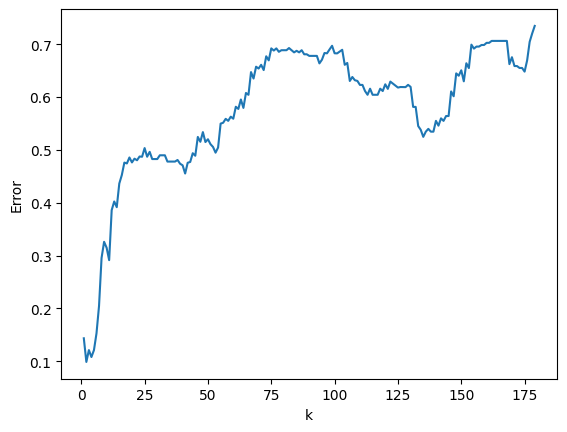

In [6]:
# Part three: cvKNN

# Define a function called cvknn, which takes the training dataset(train_data), the test dataset(tets_da# ta), 
# the range of k (k_range) and the number of fold for cross-validation as input. 
# The output of the function is the value of k (best_k) which correponds to the least error (cv_score)
# and the predicted y values with the best k

def cvknn(train_data,test_data,k_range,kcv):
    
    best_k = None
    smallest_error = float('inf')
    cv_scores = []
    
    # Define the fold of cross validation
    kf = KFold(n_splits=kcv, shuffle= True, random_state = 42) 
    
    for ik in k_range:

        error_sum = 0.0

        for train_idx, test_idx in kf.split(train_data):

            knn = KNeighborsClassifier(n_neighbors = ik)

            # Use cross-validation to evaluate the model
            X_train, X_test = train_data[train_idx,0:2], train_data[test_idx,0:2]
            Y_train, Y_test = train_data[train_idx,2], train_data[test_idx,2]
            knn.fit(X_train, Y_train)
            Y_pred = knn.predict(X_test)

            # Calculate the root mean sum error (rmse)
            mse = mean_squared_error(Y_test, Y_pred)
            rmse = math.sqrt(mse)

            
            error_sum += rmse

        avg_error = error_sum / 10

        if avg_error <= smallest_error:
            best_k = ik
            smallest_error = avg_error
            
        # Calculate and store the mean cross-validation score
        cv_scores.append(avg_error)
        
    # Apply the cvKNN with the best k
    knn_best = KNeighborsClassifier(n_neighbors = best_k)
    knn_best.fit(train_data[:,0:2], train_data[:,2])
    cvknn_pred = knn_best.predict(test_data[:,0:2])
    
    return(best_k,cv_scores,cvknn_pred)

k_range = range(1,180)
best_k, cv_scores, cvknn_pred = cvknn(train_data,test_data,k_range,10)

print("Best K chosen by 10-fold cross-validation is", best_k)
plt.plot(k_range,cv_scores)
plt.xlabel('k')
plt.ylabel('Error')

conf_cvknn = confusion_matrix(test_data[:,2],cvknn_pred)
print(conf_cvknn)
accuracy_cvknn = (conf_cvknn[0,0]+conf_cvknn[1,1])/10000
print(accuracy_cvknn)


The largest K value is picked when multiple K values give the same and smallest CV error, which corresponds to the simplest model. 

In [7]:
## Part four: Bayes fule

bayes_score = np.empty((10000, 1), dtype=float)

# Define a function to convert a row vector to a column vector
def vector_convert(vector1):
    vector2 = vector1.reshape(vector1.shape[0],1)
    return(vector2)

# Define a function called bayes_rule, which takes the test data and the centers as input
# and return the prediced y (bayes_score) by Bayes rule

def bayes_rule(test_data,centers):
    x0 = vector_convert(test_data[:,0])
    x1 = vector_convert(test_data[:,1])
    class0_dis = (x0-centers[0:10,0])**2 + (x1-centers[0:10,1])**2    
    class1_dis = (x0-centers[10:20,0])**2 + (x1-centers[10:20,1])**2
    class0_pos = np.sum(np.exp(-class0_dis/2/(var**2)),1)
    class1_pos = np.sum(np.exp(-class1_dis/2/(var**2)),1)

    bayes_score = class1_pos/class0_pos
    bayes_score[bayes_score >= 1] = 1 # when the ratio is greater or equal to 1, class one
    bayes_score[bayes_score < 1] = 0  # otherwise, class zero
    return(bayes_score) 

bayes_pred = bayes_rule(test_data,centers)

conf_bayes = confusion_matrix(test_data[:,2],bayes_pred)
accuracy_bayes = (conf_bayes[0,0] + conf_bayes[1,1])/10000

print(conf_bayes)
print(accuracy_bayes)

[[4921   79]
 [ 101 4899]]
0.982


In [8]:
# Part five: simulation study

error_knn = []
error_cvknn = []
error_bayes = []
cidx = np.array(range(0,20))
    
# Define a function called loss_01 which calculate the loss function
# The function takes the true values(values_true) and predicted values(values_predicted) as input
# and returns the loss function (loss).

def loss_01(values_true, values_predicted):
    samplesize = values_true.shape[0]
    conf_matrix = confusion_matrix(values_true,values_predicted)
    loss = (conf_matrix[0,1] + conf_matrix[1,0]) /samplesize
    return(loss)

for iloop in range(0,50):
    
    train_ = []
    test_ = []
    y_true = []
    y_knn = []
    centers_shuffle = []
    
    # Shuffle the centers
    np.random.shuffle(cidx)
    centers_shuffle = centers[cidx]
    
    # Create new sets of training and test data
    train_ = data_generation(num_samples_train,centers_shuffle,var)
    test_ = data_generation(num_samples_test,centers_shuffle,var)
    y_true = test_[:,2]
    
    # KNN method with k = 7
    y_knn = np.array(knn_binary(train_,test_,7))
    
    # KNN method combined with 10-fold cross-validation
    best_k, cv_scores, y_cvknn = cvknn(train_,test_,range(1,180),10)
    
    # Bayes method
    y_bayes = bayes_rule(test_,centers_shuffle)
    
    loss_knn = loss_01(y_true,y_knn.T)
    loss_cvknn = loss_01(y_true,y_cvknn)
    loss_bayes = loss_01(y_true,y_bayes)
    
    error_knn.append(loss_knn)
    error_cvknn.append(loss_cvknn)
    error_bayes.append(loss_bayes)

print('Successfully Finished!')
    

Successfully Finished!


The min, max, median, 25% quantile and 75% quantile of 
KNN errors:  [0.0098] [0.0949] [0.0387] [0.0327] [0.048875]
cvKNN errors [0.0096] [0.1034] [0.04065] [0.032825] [0.051025]
Bayes errors [0.0089] [0.047] [0.0284] [0.024375] [0.03435]


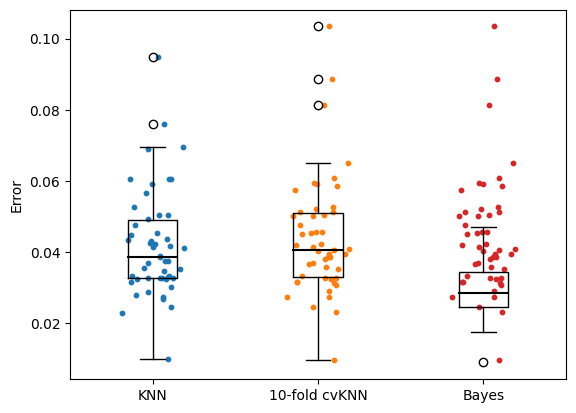

In [10]:
labels = ['KNN','10-fold cvKNN','Bayes']
error_ = [error_knn,error_cvknn,error_bayes]
plt.boxplot(x = error_,
            medianprops = dict(color = "black", linewidth = 1.5),
            labels = labels)
plt.ylabel('Error')


def stat(data):
    output = np.empty((5,1),dtype = 'float')
    data_np = np.array(data)       # Convert the data to an array
    output[0] = np.min(data_np)    # Minimum
    output[1] = np.max(data_np)    # Maximum
    output[2] = np.median(data_np) # Median
    output[3] = np.percentile(data_np, 25)   # 25% quantile
    output[4] = np.percentile(data_np, 75)   # 75% quantile
    return(output)

x0 = [1] * 50 + np.random.normal(0,0.1,50)
plt.scatter(x0, error_knn, marker='o', s = 10,  color='tab:blue', label='Error')
plt.scatter(x0+1, error_cvknn, marker='o', s = 10,  color='tab:orange', label='Error')
plt.scatter(x0+2, error_cvknn, marker='o', s = 10,  color='tab:red', label='Error')

stat_knn = stat(error_knn)
stat_cvknn = stat(error_cvknn)
stat_bayes = stat(error_bayes)


print('The min, max, median, 25% quantile and 75% quantile of ')
print('KNN errors: ' , stat_knn[0], stat_knn[1], stat_knn[2], stat_knn[3],  stat_knn[4])
print('cvKNN errors' , stat_cvknn[0], stat_cvknn[1], stat_cvknn[2], stat_cvknn[3],  stat_cvknn[4])
print('Bayes errors' , stat_bayes[0], stat_bayes[1], stat_bayes[2], stat_bayes[3],  stat_bayes[4])
